In [13]:
import os

if not os.path.exists('CelebAMask-HQ.zip'):
    !gdown --id 1badu11NqxGf6qM3PTTooQDJvQbejgbTv -O CelebAMask-HQ.zip

# !unzip -l CelebAMask-HQ.zip | grep /$

if not os.path.exists('./CelebAMask-HQ/CelebA-HQ-img/'):
    !unzip CelebAMask-HQ.zip 'CelebAMask-HQ/CelebA-HQ-img/*'

In [14]:
# Hyperparameters
model_save_path = "./model/gan-res/"

img_width = 512
img_height = 512

max_dataset_size = 30000
num_epochs = 20

lr = 0.0001
batch_size = 16

lambda_pixel = 100
D_update_interval = 3

from torchvision.transforms import transforms

# Transforms with Data Augmentation
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

In [15]:
from data_prepare import process_and_split_dataset, load_data

if not os.path.exists('./dataset/'):
    rawdata_dir = "./CelebAMask-HQ/CelebA-HQ-img/"
    process_and_split_dataset(rawdata_dir)

train_loader, val_loader, test_loader = load_data(transform, batch_size, max_dataset_size)

In [16]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)
    
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(query, key)
        attention = self.softmax(energy)
        value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        return self.gamma * out + x
    
# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # size: (64, 256, 256)

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # size: (128, 128, 128)

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # size: (256, 64, 64)

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # size: (512, 32, 32)

            # 새로운 레이어 추가
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.res_blocks = nn.Sequential(
            ResidualBlock(1024),
            ResidualBlock(1024),
            ResidualBlock(1024),
            ResidualBlock(1024)
            # 필요한 만큼의 ResidualBlock을 추가
        )
        self.attention = SelfAttention(in_dim=1024)  # Attention의 입력 차원 변경

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # size: (256, 64, 64)

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # size: (128, 128, 128)

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # size: (64, 256, 256)

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
            # size: (3, 512, 512)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.res_blocks(x)
        x = self.attention(x)
        x = self.decoder(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),  # Dropout 비율 증가

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # Dropout 추가

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # Dropout 추가

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # Dropout 추가

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(-1, 1)

In [17]:
import torch.optim as optim

# Model, Loss Function, and Optimizer Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion_GAN = nn.BCELoss()
criterion_pixelwise = nn.L1Loss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.0004, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.0001, 0.999))

def save_model(model, loss, epoch, save_path):
    # 모델의 가중치 저장
    if not os.path.exists(save_path): os.makedirs(save_path)
    generator, discriminator = model
    g_loss, d_loss = loss
    torch.save(generator.state_dict(), os.path.join(save_path, f'generator_epoch_{epoch+1}_{g_loss}_{d_loss}.pth'))
    torch.save(discriminator.state_dict(), os.path.join(save_path, f'discriminator_epoch_{epoch+1}_{g_loss}_{d_loss}.pth'))

In [18]:
from tqdm import tqdm
for epoch in range(num_epochs):
    total_G_loss = 0
    total_D_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_idx, (grayscale_imgs, real_imgs) in enumerate(pbar):
        grayscale_imgs, real_imgs = grayscale_imgs.to(device), real_imgs.to(device)

        # 먼저 fake 이미지를 생성
        fake_imgs = generator(grayscale_imgs)

        # Discriminator 업데이트 빈도에 따라 조건적으로 업데이트
        if batch_idx % D_update_interval == 0:
            optimizer_D.zero_grad()

            # Real images
            real_labels = torch.ones(grayscale_imgs.size(0), 1, device=device)
            real_loss = criterion_GAN(discriminator(real_imgs), real_labels)

            # Fake images
            fake_labels = torch.zeros(grayscale_imgs.size(0), 1, device=device)
            fake_loss = criterion_GAN(discriminator(fake_imgs.detach()), fake_labels)

            # Total discriminator loss
            D_loss = (real_loss + fake_loss) / 2
            D_loss.backward()
            optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # GAN loss
        fake_labels = torch.ones(grayscale_imgs.size(0), 1, device=device)
        GAN_loss = criterion_GAN(discriminator(fake_imgs), fake_labels)

        # Pixel-wise loss
        pixelwise_loss = criterion_pixelwise(fake_imgs, real_imgs)

        # Total generator loss
        G_loss = GAN_loss + lambda_pixel * pixelwise_loss
        G_loss.backward()
        optimizer_G.step()

        total_G_loss += G_loss.item()
        total_D_loss += D_loss.item()
        pbar.set_postfix(G_loss=G_loss.item(), D_loss=D_loss.item())

    avg_G_loss = total_G_loss / len(train_loader)
    avg_D_loss = total_D_loss / len(train_loader)
    if (epoch+1) % 5 == 0:
        save_model((generator, discriminator), (avg_G_loss, avg_D_loss), epoch, model_save_path)

Epoch 10/10: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, D_loss=0.671, G_loss=33.7]


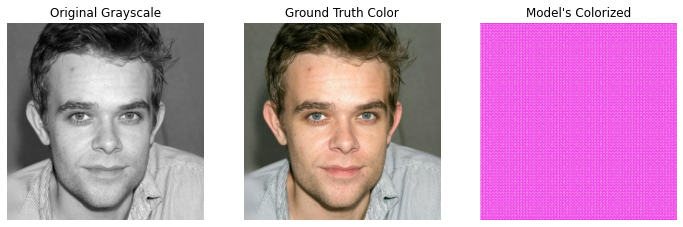

In [19]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
# Visualization of colorization results after each epoch
def model_eval(generator, test_loader, device, test_cnt):
    generator.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            for idx in range(test_cnt):
                inputs, labels = inputs.to(device), labels.to(device)
                fake_imgs = generator(inputs)

                # Displaying up to 5 examples
                plt.figure(figsize=(12, 4))

                # Original Grayscale Image
                plt.subplot(1, 3, 1)
                plt.imshow(transforms.ToPILImage()(inputs[idx].cpu()), cmap='gray')
                plt.title("Original Grayscale")
                plt.axis('off')

                # Ground Truth Color Image
                plt.subplot(1, 3, 2)
                plt.imshow(transforms.ToPILImage()(labels[idx].cpu()))
                plt.title("Ground Truth Color")
                plt.axis('off')

                # Model's Colorized Image
                plt.subplot(1, 3, 3)
                plt.imshow(transforms.ToPILImage()(fake_imgs[idx].cpu()))
                plt.title("Model's Colorized")
                plt.axis('off')

                plt.show()
model_eval(generator, test_loader, device, 1)